# 200811 Fastq kmer counts basic comparison

In [1]:
using BioSequences
using FASTX
using CodecZlib
using ProgressMeter
using PlotlyJS
using DataFrames

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-5199303977778282422\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-12364354864275817905\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-5199303977778282422\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
using Midas
using Midas.Kmers
using Midas.Search

In [3]:
using PyPlot, PyCall
sns = pyimport("seaborn")
pd = pyimport("pandas")

PyObject <module 'seaborn' from '/Users/student/anaconda/envs/modeling/lib/python3.6/site-packages/seaborn/__init__.py'>

In [4]:
infiles = Dict(
    :assembly_dir => "/Users/student/projects/midas/data/gold_standard_seqs_200726/assembled",
    :reads_dir => "/Users/student/projects/midas/data/gold_standard_seqs_200726/reads",
)

Dict{Symbol,String} with 2 entries:
  :assembly_dir => "/Users/student/projects/midas/data/gold_standard_seqs_20072…
  :reads_dir    => "/Users/student/projects/midas/data/gold_standard_seqs_20072…

## Find sequence files

In [5]:
seq_file_pairs = [
    readsfile => joinpath(infiles[:assembly_dir], split(basename(readsfile), '.')[1] * ".fasta")
    for readsfile in readdir(infiles[:reads_dir], join=true)
    if endswith(readsfile, ".fastq.gz")
]

for (reads, assembled) in seq_file_pairs
    @assert isfile(reads) && isfile(assembled)
end

length(seq_file_pairs)

80

## Defs

In [6]:
phred2p(phred) = 10 ^ (phred * -0.1)
p2phred(p) = -10 * log10(p)
phredprod(phred) = p2phred(1 - prod(1 .- phred2p.(phred)))
phredsum(phred) = p2phred(sum(phred2p.(phred)))

phredsum (generic function with 1 method)

In [7]:
# Histogram with transparency fill
function myhist(ax, x, color; alpha=.25, lw=2, kw...)
    h1 = ax.hist(x; fc=color, alpha=alpha, kw...)
    h2 = ax.hist(x; histtype=:step, ec=color, lw=lw, kw...)
    return (h1, h2)
end

myhist (generic function with 1 method)

## Search parameters

In [8]:
kspec = KmerSpec{11}(kmer"ATGAC")

query = KmerQuery(kspec)

KmerQuery{Kmer32{11},Kmer16{5}}(ATGAC, GTCAT, ExactSearchQuery{Kmer16{5}}(ATGAC, 0x0000000f, 5, 3), ExactSearchQuery{Kmer16{5}}(GTCAT, 0x0000000f, 3, 5))

In [9]:
# Choose an arbitrary pair to analyze
filepair = seq_file_pairs[3]

"/Users/student/projects/midas/data/gold_standard_seqs_200726/reads/16AC1611139-CAP_S14_L001_R1_001.fastq.gz" => "/Users/student/projects/midas/data/gold_standard_seqs_200726/assembled/16AC1611139-CAP_S14_L001_R1_001.fasta"

## Raw read counts

In [10]:
thresholds = [10, 15, 20, 25]
read_counts = zeros(Int, length(thresholds), nkmers(kspec.k));

In [11]:
let
    fastq = GzipDecompressorStream(open(filepair[1]))
    reader = FASTQ.Reader(fastq)

    nreads = 0
    prog = ProgressUnknown()

    for record in reader
        nreads += 1

        seq = sequence(record)
        phred = quality(record)

        for m in findkmers(query, seq)
            score = phredprod(phred[m.fullinds])
            ithresh = searchsortedfirst(thresholds, score) - 1
            ithresh < 1 && continue
            
            ikmer = BioSequences.encoded_data(m.kmer) + 1
            read_counts[1:ithresh, ikmer] .+= 1
        end
        
        next!(prog)
    end
    
    finish!(prog)
    
    nreads
end

Progress:  1054659 	 Time: 0:00:11


1054659

In [12]:
[count(>(0), r) for r in eachrow(read_counts)]

4-element Array{Int64,1}:
 9347
 8785
 8600
 8178

## Assembly counts

In [13]:
assembly_counts = zeros(Int, length(thresholds), nkmers(kspec.k));

In [14]:
let
    fasta = open(filepair[2])
    reader = FASTA.Reader(fasta)

    nreads = 0
    prog = ProgressUnknown()

    for record in reader
        nreads += 1

        for m in findkmers(query, sequence(record))
            ikmer = BioSequences.encoded_data(m.kmer) + 1
            assembly_counts[ikmer] += 1
        end
        
        next!(prog)
    end
    
    finish!(prog)
    
    nreads
end

Progress:  440 	 Time: 0:00:00


440

In [15]:
count(>(0), assembly_counts)

7474

## Plots

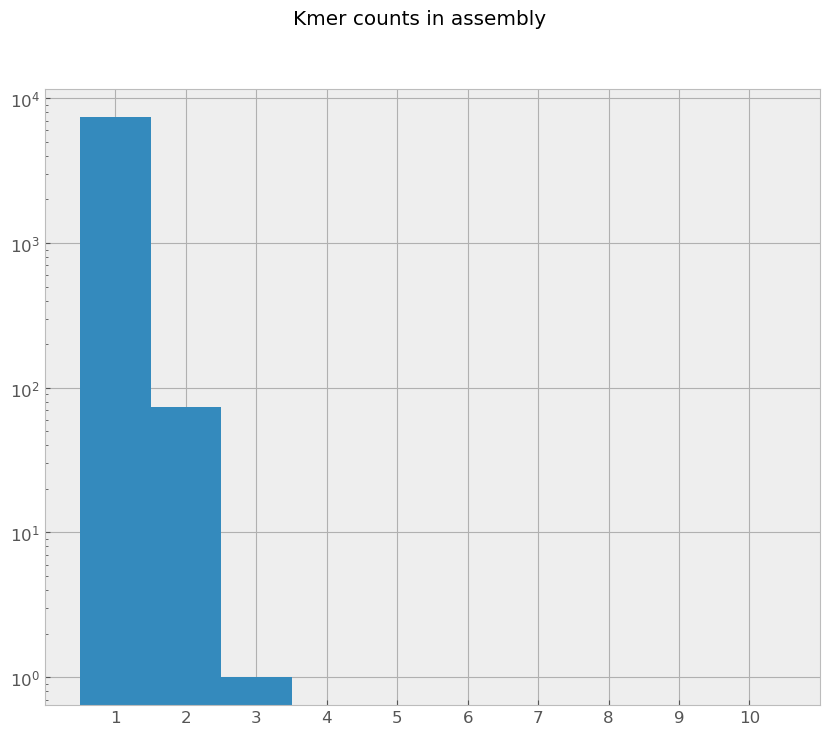

PyObject Text(0.5, 0.98, 'Kmer counts in assembly')

In [16]:
plt.hist(filter(>(0), assembly_counts), range=(.5,10.5), bins=10, log=true)
plt.xticks(1:10)
plt.suptitle("Kmer counts in assembly")

In [17]:
union_indices = [
    findall(i -> r[i] > 0 || assembly_counts[i] > 0, eachindex(r))
    for r in eachrow(read_counts)
];

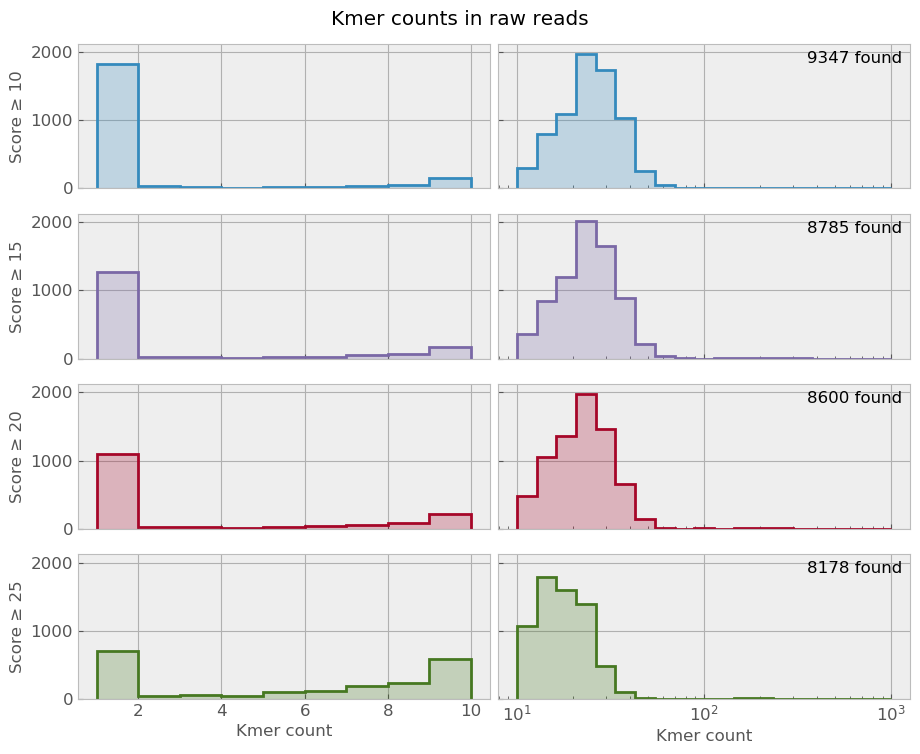

In [18]:
let
    fig, axs = plt.subplots(4, 2, sharex=:col, sharey=true)
    pal = sns.color_palette(n_colors=length(thresholds))
    
    bins1 = 1:10
    bins2 = 10 .^ LinRange(1, 3, 20)
    
    for (i, t) in enumerate(thresholds)
        ax1, ax2 = axs[i, :]
        
        vals = read_counts[i, :]
        myhist(ax1, vals, pal[i], bins=bins1)
        myhist(ax2, vals, pal[i], bins=bins2)
        
        ax1.set_ylabel("Score ≥ $t")
        
        cnt = count(>(0), view(read_counts, i, :))
        ax2.text(.98, .95, "$cnt found",
            transform=ax2.transAxes, va=:top, ha=:right)
    end
    
    axs[end, 2].set_xscale(:log)
    axs[end, 1].set_xlabel("Kmer count")
    axs[end, 2].set_xlabel("Kmer count")
    plt.suptitle("Kmer counts in raw reads")
    plt.tight_layout(pad=3, w_pad=.5, h_pad=1)
end

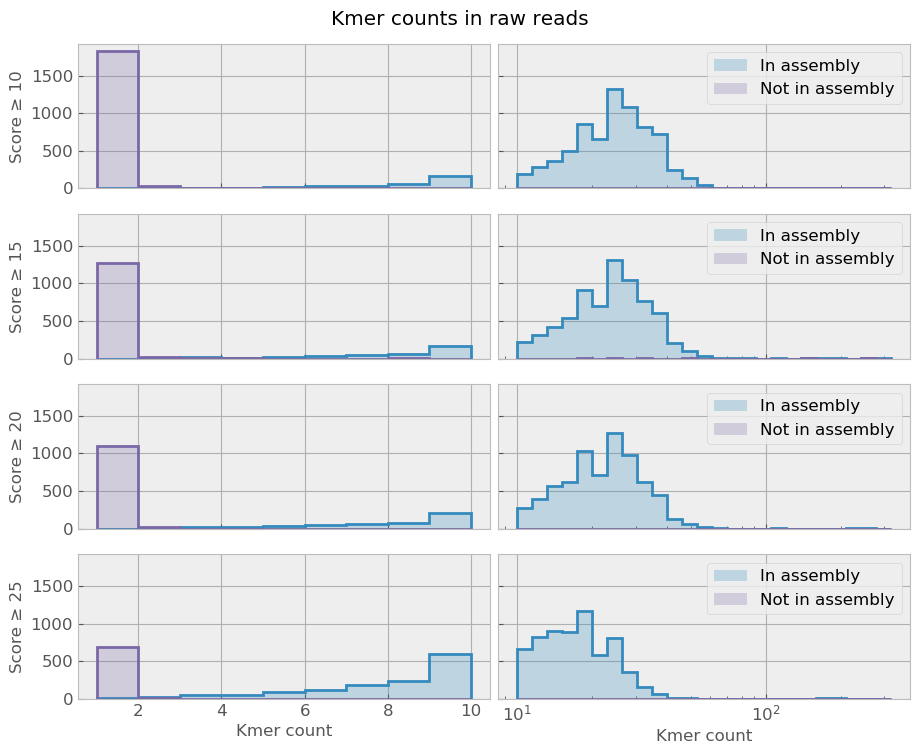

PyObject Text(0.5, 0.98, 'Kmer counts in raw reads')

In [19]:
let
    fig, axs = plt.subplots(length(thresholds), 2, sharex=:col, sharey=true)
    
    max_read = maximum(read_counts)
    nbins = 25
    bins1 = 1:10
    bins2 = 10 .^ LinRange(1, log10(max_read+1), nbins+1)
    
    pal = sns.color_palette(n_colors=2)
    alpha = 0.25
    
    for i in axes(thresholds, 1)                          
        ax1, ax2 = axs[i, :]
        idxs = union_indices[i]
        read_counts2 = @view read_counts[i, :]
        max_read = maximum(read_counts2)
    
        ax2.set_xscale(:log)
        ax1.set_ylabel("Score ≥ $(thresholds[i])")
        
        for (ax, bins) in zip([ax1, ax2], [bins1, bins2])
            h1 = myhist(ax, 
                [read_counts2[j] for j in idxs if assembly_counts[j] > 0],
                pal[1],
                bins=bins)
            h2 = myhist(ax, 
                [read_counts2[j] for j in idxs if assembly_counts[j] == 0],
                pal[2],
                bins=bins)

            ax === ax2 && ax.legend([h1[1][3][1], h2[1][3][1]], ["In assembly", "Not in assembly"])
        end
    end
    
    axs[end, 1].set_xlabel("Kmer count")
    axs[end, 2].set_xlabel("Kmer count")
    
    fig.tight_layout(pad=3, w_pad=.5, h_pad=1)
    plt.suptitle("Kmer counts in raw reads")
end

## Accuracy

In [21]:
count_thresholds = vcat(1:5, 10)

6-element Array{Int64,1}:
  1
  2
  3
  4
  5
 10

In [22]:
counts_df = let
    rows = Any[]
    kmer_in_assembly = assembly_counts .>= 1
    
    for (i, score_thresh) in enumerate(thresholds), count_thresh in count_thresholds
        kmer_in_read = @view(read_counts[i, :]) .>= count_thresh
        for in_read in [false, true], in_assembly in [false, true]
            c = count(i -> kmer_in_read[i] == in_read && kmer_in_assembly[i] == in_assembly, 1:nkmers(kspec.k))
            push!(rows, (score_thresh, count_thresh, in_read, in_assembly, c))
        end
    end
    
    cols = [:score_threshold, :count_threshold, :in_reads, :in_assembly, :count]
    pd.DataFrame.from_records(rows, columns=cols).set_index(cols[1:end-1])
end

PyObject                                                         count
score_threshold count_threshold in_reads in_assembly         
10              1               False    False        4184957
                                         True               0
                                True     False           1873
                                         True            7474
                2               False    False        4186787
...                                                       ...
25              5               True     True            7348
                10              False    False        4186823
                                         True            1054
                                True     False              7
                                         True            6420

[96 rows x 1 columns]

In [23]:
confusion = counts_df.unstack([:count_threshold, :in_reads])

PyObject                                count                 ...                     
count_threshold                   1              2   ...    5        10      
in_reads                       False True     False  ... True     False True 
score_threshold in_assembly                          ...                     
10              False        4184957  1873  4186787  ...     8  4186823     7
                True               0  7474        0  ...  7448      228  7246
15              False        4185519  1311  4186796  ...     8  4186823     7
                True               0  7474        0  ...  7444      266  7208
20              False        4185704  1126  4186800  ...     8  4186823     7
                True               0  7474        1  ...  7434      330  7144
25              False        4186125   705  4186810  ...     8  4186823     7
                True               1  7473       10  ...  7348     1054  6420

[8 rows x 12 columns]

In [24]:
pr_df = counts_df.groupby([:score_threshold, :count_threshold]).apply() do g
    g = py"$g['count']".reset_index([:score_threshold, :count_threshold], drop=true)
    tp = py"$g.loc[True, True]"
    fp = py"$g.loc[True, False]"
    fn = py"$g.loc[False, True]"
    return pd.Series([tp / (tp + fp), tp / (tp + fn), tp / (tp + fn + fp)], index=[:precision, :recall, :jaccard])
end

PyObject                                  precision    recall   jaccard
score_threshold count_threshold                               
10              1                 0.799615  1.000000  0.799615
                2                 0.994280  1.000000  0.994280
                3                 0.998396  0.999599  0.997996
                4                 0.998795  0.998127  0.996926
                5                 0.998927  0.996521  0.995456
                10                0.999035  0.969494  0.968587
15              1                 0.850768  1.000000  0.850768
                2                 0.995471  1.000000  0.995471
                3                 0.998530  0.999465  0.997996
                4                 0.998794  0.997592  0.996392
                5                 0.998926  0.995986  0.994921
                10                0.999030  0.964410  0.963508
20              1                 0.869070  1.000000  0.869070
                2                 0.996002  0.999866  0.995869
                3                 0.998663  0.999197  0.997862
                4                 0.998793  0.996655  0.995456
                5                 0.998925  0.994648  0.993585
                10                0.999021  0.955847  0.954953
25              1                 0.913793  0.999866  0.913681
                2                 0.997328  0.998662  0.995997
                3                 0.998926  0.995451  0.994387
                4                 0.998919  0.989162  0.988105
                5                 0.998912  0.983142  0.982090
                10                0.998911  0.858978  0.858174

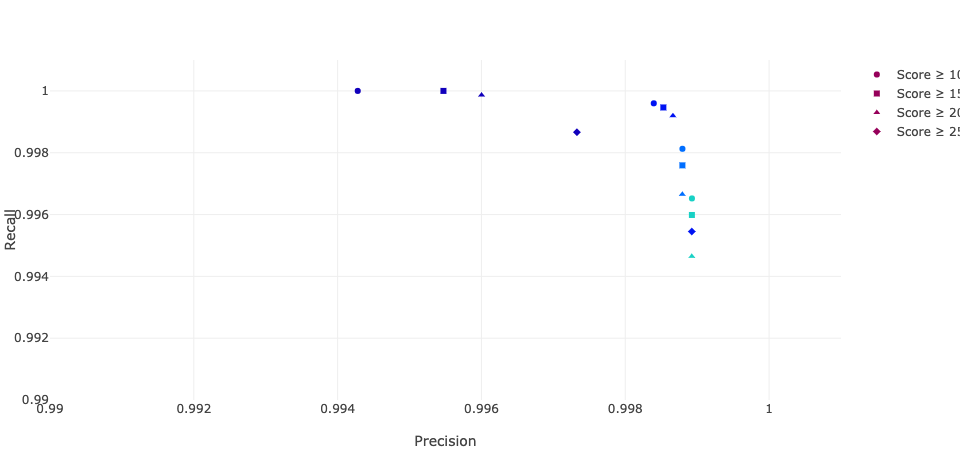

In [25]:
let
    df2 = DataFrame(pr_df.reset_index().to_dict(orient=:list))
    gb = groupby(df2, :score_threshold)
    
    traces = PlotlyJS.GenericTrace[]
    symbols = ["circle", "square", "triangle-up", "diamond"]
    
    for ((k, g), symbol) in zip(pairs(gb), symbols)
        push!(traces, PlotlyJS.scatter(g,
            x=:precision,
            y=:recall,
            mode=:markers,
            marker_color=:count_threshold,
            marker_symbol=symbol,
            marker_colorscale="Rainbow",
#             marker_colorbar_cmax=6,
            name="Score ≥ $(k.score_threshold)",
            hovertemplate = """
                Precision: %{x:.4f}<br>
                Recall: %{y:.4f}<br>
                Count threshold: %{marker.color}
            """,
        ))
    end
    
    layout = PlotlyJS.Layout(
        xaxis=attr(
            title="Precision",
            range=[.99, 1.001],
        ),
        yaxis=attr(
            title="Recall",
            range=[.99, 1.001],
        ),
        hovermode=:closest,
    )
    
    PlotlyJS.plot(traces, layout)
end